In [1]:
# TODOS :
'''
M2 knockdown
IFN initial concentration to depend on baseline IFN secretion
'''

'\nM2 knockdown\nIFN initial concentration to depend on baseline IFN secretion\n'

In [2]:
# DELTE OUTPUT FILE IF EXISTS
import os # Work with system folders and files
working_dir = os.getcwd()
output_folder = os.path.join(working_dir, "output")
file_name = f'output.txt'
output_file = os.path.join(output_folder, file_name)
if os.path.exists(output_file):
    os.remove(output_file)
    print(f"Deleted: {output_file}")
else:
    print(f"File not found: {output_file}")

Deleted: C:\Trabalhos\APL_Project\output\output.txt


In [3]:
# IMPORTS

from cc3d.CompuCellSetup.CC3DCaller import CC3DSimService # Needed to instantiate simulations

# Import plugins to be used in the simulation
from cc3d.core.PyCoreSpecs import (PottsCore,
                                   Metadata,
                                   CellTypePlugin,
                                   VolumePlugin, 
                                   CenterOfMassPlugin,
                                   NeighborTrackerPlugin,
                                   ExternalPotentialPlugin, 
                                   AdhesionFlexPlugin,
                                   ContactPlugin,
                                   ChemotaxisPlugin,
                                   ChemotaxisParameters,
                                   ChemotaxisTypeParameters,
                                   SecretionPlugin,
                                   DiffusionSolverFE,
                                   BlobInitializer,
                                   PIFInitializer,
                                   UniformInitializer)

from cc3d.core.PySteppables import *
import numpy as np
from time import time # Useful to track execution time
import os # Work with system folders and files
import random

# Import widgets to visualize simulations in Jupyter Notebooks
from IPython.display import display
from cc3d.core.GraphicsUtils.JupyterGraphicsFrameWidget import CC3DJupyterGraphicsFrameGrid as cc3djgf
import ipywidgets as widgets
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# from VM_steppable import analysisSteppable

C:\Users\pdalc\anaconda3\envs\cc3d_460_310\lib\site-packages\cc3d\core\Configuration\SettingUtils.py:248: UserWarning: Setting not set: PlayerSizes
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')
C:\Users\pdalc\anaconda3\envs\cc3d_460_310\lib\site-packages\cc3d\core\Configuration\SettingUtils.py:248: UserWarning: Setting not set: PlayerSizesFloating
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')
C:\Users\pdalc\anaconda3\envs\cc3d_460_310\lib\site-packages\cc3d\core\Configuration\SettingUtils.py:248: UserWarning: Setting not set: RecentSimulations
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')


In [4]:
# INTRACELLULAR MODEL STRING FORMATTING FUNCTION

def custom_format(template, placeholders):
    for key, value in placeholders.items():
        template = template.replace(f"<<{key}>>", str(value))
    return template

In [7]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Define initial data
data = [
    {"Variable Name": "secretion_rate_V", "Value": 1900./6., "Description": "Number of viruses released per MCS per cell in the 'releasing' state"},
    {"Variable Name": "secretion_rate_IFN", "Value": 4.55, "Description": "Amount of IFN cells secrete per MCS once IFNmRNA gets active"},
    {"Variable Name": "IRF7_secretion_multiplier", "Value": 10, "Description": "Multiplier of IFN secretion when IFR7 is active"},
    {"Variable Name": "IFITM_effectiveness", "Value": 0.96, "Description": "Percent decrease in the virus endocytosis probability"},
    {"Variable Name": "IFN_stimulation_threshold", "Value": 0.00001, "Description": "This is a performance-enhancing parameter only"},
    {"Variable Name": "endocytosis_prob_", "Value": 0.1, "Description": "Probability a cell endocytosing a viral particle per MCS"},
    {"Variable Name": "death_prob", "Value": (1./6)*(1./5), "Description": "Probability of a cell dying per MCS in the 'producing' state"},
    {"Variable Name": "IFNn", "Value": 4, "Description": "Hill Function exponent, controls the steepness of the ISG activation to IFN concentration at the half max"},
    {"Variable Name": "IFNhm", "Value": 1, "Description": "Hill Function half max, controls the concentration at which ISGs get half the activation rate in response to IFN"},
    {"Variable Name": "NS1_del", "Value": 0, "Description": "(Binary) Disables NS1 in the model"},
    {"Variable Name": "virus_diffusion", "Value": 0.63, "Description": "Diffusion rate of the virus field"},
    {"Variable Name": "virus_decay", "Value": 0, "Description": "Decay rate of the virus field"},
    {"Variable Name": "IFN_diffusion", "Value": 31.0, "Description": "Diffusion rate of the IFN field"},
    {"Variable Name": "IFN_decay", "Value": 1/54*1/6, "Description": "Decay rate of the IFN field"},
    {"Variable Name": "initial_IFN_concentration", "Value": 0.01, "Description": "Initial concentration of the IFN field"},
    {"Variable Name": "secretion_rate_IFN_baseline", "Value": (1/54*1/6)*0.01, "Description": "Amount of IFN per MCS that cells release when they are not infected"},
    {"Variable Name": "MOI_PFU", "Value": 0.0012, "Description": "Number of seeded viruses (infectious) per cell"},
    {"Variable Name": "PB1g", "Value": 0.567211899, "Description": "Defect rate of the PB1 gene"},
    {"Variable Name": "PB2g", "Value": 0.568645964, "Description": "Defect rate of the PB2 gene"},
    {"Variable Name": "PAg", "Value": 0.547128424, "Description": "Defect rate of the PA gene"},
    {"Variable Name": "NS1g", "Value": 0.224665344, "Description": "Defect rate of the NS1 gene"},
    {"Variable Name": "NPg", "Value": 0.424879137, "Description": "Defect rate of the NPg gene"},
    {"Variable Name": "HAg", "Value": 0.464785577, "Description": "Defect rate of the HA gene"},
    {"Variable Name": "NAg", "Value": 0.402172369, "Description": "Defect rate of the NA gene"},
    {"Variable Name": "M1g", "Value": 0.243308949, "Description": "Defect rate of the M1 gene"},
    {"Variable Name": "M2g", "Value": 0.101758182, "Description": "Defect rate of the M2 gene"},
    {"Variable Name": "NEPg", "Value": 0.125294801, "Description": "Defect rate of the NEP gene"},
    {"Variable Name": "vRNP_import_time", "Value": 3, "Description": "Average time between infection and activation of vRNPn node"},
    {"Variable Name": "intracellular_virus_decay_time", "Value": 10, "Description": "Average time of vRNPn node downregulation"},
    {"Variable Name": "protein_degradation_time", "Value": 24, "Description": "Average time of viral protein nodes downregulation"},
    {"Variable Name": "RC_formation_time", "Value": 0.0001, "Description": "Average time for the formation of the replication complex (NP+PB1+PB2+PA)"},
    {"Variable Name": "RC_degradation_time", "Value": 10, "Description": "Average time of the replication complex downregulation"},
    {"Variable Name": "mRNA_degradation_time", "Value": 12, "Description": "Average time of host mRNA downregulation"},
    {"Variable Name": "IFITM_downregulation_time", "Value": 24, "Description": "Average time of host IFITM downregulation"},
    {"Variable Name": "virus_replication_time", "Value": 1, "Description": "Average time of activating the 'releasing' state once vRNPn node is active"},
    {"Variable Name": "protein_production_time", "Value": 1, "Description": "Average time of viral protein nodes upregulation once vRNPn is active"},
    {"Variable Name": "mRNA_upregulation_time", "Value": 4, "Description": "Average time of host mRNA upregulation"},
    {"Variable Name": "IFITM_upregulation_time", "Value": 12, "Description": "Average time of host IFITM upregulation"}
]

# Create widgets for each row
rows = []
for row in data:
    name = widgets.Text(value=row["Variable Name"], disabled=True)
    value = widgets.Text(value=str(row["Value"]))
    desc = widgets.Text(value=row["Description"], disabled=True)
    rows.append([name, value, desc])

# Display table headers
header = widgets.HBox([widgets.Label("Variable Name", layout=widgets.Layout(width='300px')),
                       widgets.Label("Value", layout=widgets.Layout(width='300px')),
                       widgets.Label("Description", layout=widgets.Layout(width='250px'))])
display(header)

# Display each row
for row_widgets in rows:
    display(widgets.HBox(row_widgets))
    button = widgets.Button(description="Convert to Dictionary")
output = widgets.Output()

params = {}
for row_widgets in rows:
    var_name = row_widgets[0].value
    var_value = row_widgets[1].value
    try:
        # Try to convert to float or int if possible
        var_value = eval(var_value)
    except:
        pass
    params[var_name] = var_value

def on_button_click(b):
    params = {}
    for row_widgets in rows:
        var_name = row_widgets[0].value
        var_value = row_widgets[1].value
        try:
            # Try to convert to float or int if possible
            var_value = eval(var_value)
        except:
            pass
        params[var_name] = var_value
    with output:
        output.clear_output()
        print("Resulting Params Dictionary:")
        print(params)

button.on_click(on_button_click)
display(button, output)

Button(description='Convert to Dictionary', style=ButtonStyle())

Output()

In [7]:
# INTRACELLULAR MODEL STRINGS

virus_IFN_mbs = """

// viral replication phases
// TODO : make innate immunity defenses imperfect to allow disease spread

node vRNPn
{
    logic = $internalized_virus > 0;
    rate_up = @logic ? $vRNP_import : 0.0;
    rate_down = @logic ? 0.0 : 0.0;
}

node Producing
{
    logic = vRNPn && RC;
    rate_up = @logic ? $virus_replication : 0.0;
    rate_down = @logic ? 0.0 : $virus_decay;
}

node Releasing
{
    logic = Producing && HA && NA && M1 && M2 && NEP;
    rate_up = @logic ? 1000.0 : 0.0; // instantaneous transition
    rate_down = @logic ? 0.0 : 1.0;
}

// viral proteins, replication capacity

node PB1
{
    logic = $PB1g > 0 && vRNPn && !(OAS || PKR);
    rate_up = @logic ? $protein_production : 0.0;
    rate_down = @logic ? 0.0 : $protein_degradation;
}

node PB2
{
    logic = $PB2g > 0 && vRNPn && !(OAS || PKR);
    rate_up = @logic ? $protein_production : 0.0;
    rate_down = @logic ? 0.0 : $protein_degradation;
}

node PA
{
    logic = $PAg > 0 && vRNPn && !(OAS || PKR);
    rate_up = @logic ? $protein_production : 0.0;
    rate_down = @logic ? 0.0 : $protein_degradation;
}

node NP
{
    logic = $NPg > 0 && vRNPn && !(OAS || PKR);
    rate_up = @logic ? $protein_production : 0.0;
    rate_down = @logic ? 0.0 : $protein_degradation;
}

node RC
{
    logic = PB1 && PB2 && PA && NP;
    rate_up = @logic ? $RC_formation : 0.0;
    rate_down = @logic ? 0.0 : $RC_degradation;
}

node NS1
{
    logic = $NS1g > 0 && vRNPn && !(OAS || PKR); //ns1del
    rate_up = @logic*!($NS1_del) ? $protein_production : 0.0;
    rate_down = @logic*!($NS1_del) ? 0.0 : $protein_degradation;
}

node HA
{
    logic = $HAg > 0 && vRNPn && !(OAS || PKR);
    rate_up = @logic ? $protein_production : 0.0;
    rate_down = @logic ? 0.0 : $protein_degradation;
}

node NA
{
    logic = $NAg > 0 && vRNPn && !(OAS || PKR);
    rate_up = @logic ? $protein_production : 0.0;
    rate_down = @logic ? 0.0 : $protein_degradation;
}

node M1
{
    logic = $M1g > 0 && vRNPn && !(OAS || PKR);
    rate_up = @logic ? $protein_production : 0.0;
    rate_down = @logic ? 0.0 : $protein_degradation;
}

node M2
{
    logic = $M2g > 0 && vRNPn && !(OAS || PKR);
    rate_up = @logic ? $protein_production : 0.0;
    rate_down = @logic ? 0.0 : $protein_degradation;
}

node NEP
{
    logic = $NEPg > 0 && vRNPn && !(OAS || PKR);
    rate_up = @logic ? $protein_production : 0.0;
    rate_down = @logic ? 0.0 : $protein_degradation;
}

// Sensing viruses, producing IFN

node RIGI
{
    logic = 1; // TODO : NS1 downregulates RIGI
    rate_up = @logic ? 0.0 : 0.0;
    rate_down = @logic ? 0.0 : 0.0;
}

node IRF3
{
    logic = 1; // TODO : RIGI eventually goes low when both vRNPn and RIGI are activated
    rate_up = @logic ? 0.0 : 0.0;
    rate_down = @logic ? 0.0 : 0.0;
}

node TLR7
{
    logic = 1; // TODO : TLR7 goes to 1 immediately after internalized virus and decays with vRNP_import rate, block TLR7 pathway when endocytosis is blocked
    rate_up = @logic ? 0.0 : 0.0;
    rate_down = @logic ? 0.0 : 0.0;
}

node IFNmRNA 
{
    logic = (((IRF3 || IRF7) && (RIGI && vRNPn)) || (TLR7 && IRF7 && vRNPn)) and ! NS1; // TODO : NS1 should not allow this to go up, but also not pull it down
    // TODO : TLR7 pathway being active all the time could make NS1 inhibition of RIGI unimportant
    rate_up = @logic ? $mRNA_upregulation : 0.0;
    rate_down = @logic ? 0.0 : $mRNA_degradation; // TODO : maybe NS1 does bring this down by shutting down host transcription
}

// IFN stimulation and ISGs

// *(1.0-$IFN_hill_fuction)

node IFITM
{
    logic = $IFNc > 0 && !(NS1);
    rate_up = @logic ? $IFITM_upregulation*$IFN_hill_fuction : 0.0; 
    //rate_up = @logic ? 0.0 : 0.0; //change here
    rate_down = @logic ? $IFITM_downregulation : $IFITM_downregulation;
}

node OAS
{
    logic = $IFNc > 0 && !(NS1);
    rate_up = @logic ? $mRNA_upregulation*$IFN_hill_fuction : 0.0; 
    //rate_up = @logic ? 0.0 : 0.0; //change here
    rate_down = @logic ? $mRNA_degradation : $mRNA_degradation;
}

node PKR
{
    logic = $IFNc > 0 && !(NS1);
    rate_up = @logic ? $mRNA_upregulation*$IFN_hill_fuction : 0.0; 
    //rate_up = @logic ? 0.0 : 0.0; //change here
    rate_down = @logic ? $mRNA_degradation : $mRNA_degradation;
}

node IRF7
{
    logic = $IFNc > 0 && !(NS1); 
    rate_up = @logic ? $mRNA_upregulation*$IFN_hill_fuction : 0.0; 
    rate_down = @logic ? $mRNA_degradation : $mRNA_degradation;
}


"""

virus_IFN_mbs_config_unformated = """

$PB1g = 0;
$PB2g = 0;
$PAg = 0;
$NPg = 0;
$NS1g = 0;
$HAg = 0;
$NAg = 0;
$M1g = 0;
$M2g = 0;
$NEPg = 0;

$vRNP_import = 1.0/(<<vRNP_import_time>>*6.0); //1h
$virus_decay = 1.0/(<<intracellular_virus_decay_time>>*6.0); //10h
$protein_degradation = 1.0/(<<protein_degradation_time>>*6.0); //1h
$RC_formation = 1.0/(<<RC_formation_time>>*6.0); //instantaneous
$RC_degradation = 1.0/(<<RC_degradation_time>>*6.0); //1h
$mRNA_degradation = 1.0/(<<mRNA_degradation_time>>*6.0); //12h
$IFITM_downregulation = 1.0/(<<IFITM_downregulation_time>>*6.0); //24h

$virus_replication = 1.0/(<<virus_replication_time>>*6.0); //5h
$protein_production = 1.0/(<<protein_production_time>>*6.0); //6min
$mRNA_upregulation = 1.0/(<<mRNA_upregulation_time>>*6.0); //6h
$IFITM_upregulation = 1.0/(<<IFITM_upregulation_time>>*6.0); //12h

$IFN_hill_fuction = 0.0;
$internalized_virus = 0;
$IFNc = 0.0;
$NS1_del = 0.0;
//$IFNh = 10.0;
//$IFNn = 4.0;

RIGI.istate = 1;
IRF3.istate = 1;
TLR7.istate = 1;
IRF7.istate = 0;
IFNmRNA.istate = 0;
PB1.istate = 0;
PB2.istate = 0;
PA.istate = 0;
NP.istate = 0;
NS1.istate = 0;
HA.istate = 0;
NA.istate = 0;
M1.istate = 0;
M2.istate = 0;
NEP.istate = 0;
RC.istate = 0;
IFITM.istate = 0;
OAS.istate = 0;
PKR.istate = 0;
vRNPn.istate = 0;
Producing.istate = 0;
Releasing.istate = 0;

"""

In [8]:
pixel_size = 1.26
min_mcs = 10.0  # min/mcs
hours_mcs = min_mcs / 60.0  # hours/mcs
days_mcs = min_mcs / 1440.0  # day/mcs
hours_to_simulate = 160.0
secretion_rate_V = params['secretion_rate_V']
secretion_rate_IFN = params['secretion_rate_IFN']
IRF7_secretion_multiplier = params['IRF7_secretion_multiplier']
IFITM_effectiveness = params['IFITM_effectiveness']
IFN_stimulation_threshold = params['IFN_stimulation_threshold']
endocytosis_prob_ = params['endocytosis_prob_']
death_prob = params['death_prob']
IFNn = params['IFNn']
IFNhm = params['IFNhm']
NS1_del = params['NS1_del']
vRNP_import_time = params['vRNP_import_time']
intracellular_virus_decay_time = params['intracellular_virus_decay_time']
protein_degradation_time = params['protein_degradation_time']
RC_formation_time = params['RC_formation_time']
RC_degradation_time = params['RC_degradation_time']
mRNA_degradation_time = params['mRNA_degradation_time']
IFITM_upregulation_time = params['IFITM_upregulation_time']
IFITM_downregulation_time = params['IFITM_downregulation_time']
mRNA_upregulation_time = params['mRNA_upregulation_time']
protein_production_time = params['protein_production_time']
virus_replication_time = params['virus_replication_time']
virus_diffusion = params['virus_diffusion']
virus_decay = params['virus_decay']
IFN_diffusion = params['IFN_diffusion']
IFN_decay = params['IFN_decay']
initial_IFN_concentration = params['initial_IFN_concentration']
secretion_rate_IFN_baseline = params['secretion_rate_IFN_baseline']
MOI_PFU = params['MOI_PFU']
MOI_mixed = MOI_PFU*(100+1.5)/1.5 # viruses per cell
infection_initialization_type = "mixed virus sample"


# GDP = genome defect probabilities
GDP = {"PB1g":params['PB1g'],
       "PB2g":params['PB2g'],
       "PAg":params['PAg'],
       "NS1g":params['NS1g'],
       "NPg":params['NPg'],
       "HAg":params['HAg'],
       "NAg":params['NAg'],
       "M1g":params['M1g'],
       "M2g":params['M2g'],
       "NEPg":params['NEPg']}# INTRACELLULAR MODEL DEFAULT PARAMETERS

values = {
    "vRNP_import_time": vRNP_import_time,
    "intracellular_virus_decay_time": intracellular_virus_decay_time,
    "protein_degradation_time": protein_degradation_time,
    "RC_formation_time": RC_formation_time,
    "RC_degradation_time": RC_degradation_time,
    "mRNA_degradation_time": mRNA_degradation_time,
    "IFITM_downregulation_time": IFITM_downregulation_time,
    "virus_replication_time": virus_replication_time,
    "protein_production_time": protein_production_time,
    "mRNA_upregulation_time": mRNA_upregulation_time,
    "IFITM_upregulation_time": IFITM_upregulation_time,
}

virus_IFN_mbs_config = custom_format(virus_IFN_mbs_config_unformated, values)
#print(virus_IFN_mbs_config)

In [9]:
# # SLIDER CONFIGURATIONS
# style = {'description_width': 'initial'}


# sl_initial_infected_fraction = widgets.FloatSlider(
#     value=initial_infected_fraction,
#     min=0.0,
#     max=0.1,
#     step=0.0001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_initial_infected_fraction = widgets.Label(value="Init. Infected Frac.")

# # Create an HBox with label on the left and widget on the right
# hbox_initial_infected_fraction = widgets.HBox([label_initial_infected_fraction, sl_initial_infected_fraction],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_initial_infected_fraction(change):
#     global initial_infected_fraction
#     initial_infected_fraction = change['new']
# sl_initial_infected_fraction.observe(handle_initial_infected_fraction, names='value')

# sl_initial_IFN_concentration = widgets.FloatSlider(
#     value=initial_IFN_concentration,
#     min=0.0,
#     max=0.1,
#     step=0.00001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_initial_IFN_concentration = widgets.Label(value="Init. IFN conc.")

# # Create an HBox with label on the left and widget on the right
# hbox_initial_IFN_concentration = widgets.HBox([label_initial_IFN_concentration, sl_initial_IFN_concentration],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_initial_IFN_concentration(change):
#     global initial_IFN_concentration
#     initial_IFN_concentration = change['new']
# sl_initial_IFN_concentration.observe(handle_initial_IFN_concentration, names='value')

# sl_IFN_decay = widgets.FloatLogSlider(
#     value=IFN_decay,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.00001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_IFN_decay = widgets.Label(value="IFN Decay")

# # Create an HBox with label on the left and widget on the right
# hbox_IFN_decay = widgets.HBox([label_IFN_decay, sl_IFN_decay],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_IFN_decay(change):
#     global IFN_decay
#     IFN_decay = change['new']
# sl_IFN_decay.observe(handle_IFN_decay, names='value')

# sl_IFN_diffusion = widgets.FloatLogSlider(
#     value=IFN_diffusion,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_IFN_diffusion = widgets.Label(value="IFN Diffusion")

# # Create an HBox with label on the left and widget on the right
# hbox_IFN_diffusion = widgets.HBox([label_IFN_diffusion, sl_IFN_diffusion],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_IFN_diffusion(change):
#     global IFN_diffusion
#     IFN_diffusion = change['new']
# sl_IFN_diffusion.observe(handle_IFN_diffusion, names='value')

# sl_virus_diffusion = widgets.FloatLogSlider(
#     value=virus_diffusion,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_virus_diffusion = widgets.Label(value="Virus Diffusion")

# # Create an HBox with label on the left and widget on the right
# hbox_virus_diffusion = widgets.HBox([label_virus_diffusion, sl_virus_diffusion],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_virus_diffusion(change):
#     global virus_diffusion
#     virus_diffusion = change['new']
# sl_virus_diffusion.observe(handle_virus_diffusion, names='value')

# sl_virus_decay = widgets.FloatLogSlider(
#     value=virus_decay,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_virus_decay = widgets.Label(value="Virus Decay")

# # Create an HBox with label on the left and widget on the right
# hbox_virus_decay = widgets.HBox([label_virus_decay, sl_virus_decay],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_virus_decay(change):
#     global virus_decay
#     virus_decay = change['new']
# sl_virus_decay.observe(handle_virus_decay, names='value')

# sl_STATp_activation_time = widgets.FloatLogSlider(
#     value=STATp_activation_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_STATp_activation_time = widgets.Label(value="STATp activ. av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_STATp_activation_time = widgets.HBox([label_STATp_activation_time, sl_STATp_activation_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_STATp_activation_time(change):
#     global STATp_activation_time
#     STATp_activation_time = change['new']
# sl_STATp_activation_time.observe(handle_STATp_activation_time, names='value')

# sl_virus_replication_time = widgets.FloatLogSlider(
#     value=virus_replication_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_virus_replication_time = widgets.Label(value="Virus replic. upreg. av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_virus_replication_time = widgets.HBox([label_virus_replication_time, sl_virus_replication_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_virus_replication_time(change):
#     global virus_replication_time
#     virus_replication_time = change['new']
# sl_virus_replication_time.observe(handle_virus_replication_time, names='value')

# sl_protein_production_time = widgets.FloatLogSlider(
#     value=protein_production_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_protein_production_time = widgets.Label(value="Protein prod. upreg. av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_protein_production_time = widgets.HBox([label_protein_production_time, sl_protein_production_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_protein_production_time(change):
#     global protein_production_time
#     protein_production_time = change['new']
# sl_protein_production_time.observe(handle_protein_production_time, names='value')

# sl_mRNA_upregulation_time = widgets.FloatLogSlider(
#     value=mRNA_upregulation_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_mRNA_upregulation_time = widgets.Label(value="mRNA upreg. av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_mRNA_upregulation_time = widgets.HBox([label_mRNA_upregulation_time, sl_mRNA_upregulation_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_mRNA_upregulation_time(change):
#     global mRNA_upregulation_time
#     mRNA_upregulation_time = change['new']
# sl_mRNA_upregulation_time.observe(handle_mRNA_upregulation_time, names='value')

# sl_IFITM_downregulation_time = widgets.FloatLogSlider(
#     value=IFITM_downregulation_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_IFITM_downregulation_time = widgets.Label(value="IFITM downreg. av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_IFITM_downregulation_time = widgets.HBox([label_IFITM_downregulation_time, sl_IFITM_downregulation_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_IFITM_downregulation_time(change):
#     global IFITM_downregulation_time
#     IFITM_downregulation_time = change['new']
# sl_IFITM_downregulation_time.observe(handle_IFITM_downregulation_time, names='value')

# sl_IFITM_upregulation_time = widgets.FloatLogSlider(
#     value=IFITM_upregulation_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_IFITM_upregulation_time = widgets.Label(value="IFITM upreg. av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_IFITM_upregulation_time = widgets.HBox([label_IFITM_upregulation_time, sl_IFITM_upregulation_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_IFITM_upregulation_time(change):
#     global IFITM_upregulation_time
#     IFITM_upregulation_time = change['new']
# sl_IFITM_upregulation_time.observe(handle_IFITM_upregulation_time, names='value')

# sl_mRNA_degradation_time = widgets.FloatLogSlider(
#     value=mRNA_degradation_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_mRNA_degradation_time = widgets.Label(value="mRNA degrad. av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_mRNA_degradation_time = widgets.HBox([label_mRNA_degradation_time, sl_mRNA_degradation_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_mRNA_degradation_time(change):
#     global mRNA_degradation_time
#     mRNA_degradation_time = change['new']
# sl_mRNA_degradation_time.observe(handle_mRNA_degradation_time, names='value')

# sl_RC_degradation_time = widgets.FloatLogSlider(
#     value=RC_degradation_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_RC_degradation_time = widgets.Label(value="Replic. Complex degrad. av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_RC_degradation_time = widgets.HBox([label_RC_degradation_time, sl_RC_degradation_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_RC_degradation_time(change):
#     global RC_degradation_time
#     RC_degradation_time = change['new']
# sl_RC_degradation_time.observe(handle_RC_degradation_time, names='value')

# sl_RC_formation_time = widgets.FloatLogSlider(
#     value=RC_formation_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_RC_formation_time = widgets.Label(value="Replic. Complex formation av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_RC_formation_time = widgets.HBox([label_RC_formation_time, sl_RC_formation_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_RC_formation_time(change):
#     global RC_formation_time
#     RC_formation_time = change['new']
# sl_RC_formation_time.observe(handle_RC_formation_time, names='value')

# sl_protein_degradation_time = widgets.FloatLogSlider(
#     value=protein_degradation_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_protein_degradation_time = widgets.Label(value="Protein degrad. av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_protein_degradation_time = widgets.HBox([label_protein_degradation_time, sl_protein_degradation_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_protein_degradation_time(change):
#     global protein_degradation_time
#     protein_degradation_time = change['new']
# sl_protein_degradation_time.observe(handle_protein_degradation_time, names='value')

# sl_intracellular_virus_decay_time = widgets.FloatLogSlider(
#     value=intracellular_virus_decay_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_intracellular_virus_decay_time = widgets.Label(value="Intracel. virus decay av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_intracellular_virus_decay_time = widgets.HBox([label_intracellular_virus_decay_time, sl_intracellular_virus_decay_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_intracellular_virus_decay_time(change):
#     global intracellular_virus_decay_time
#     intracellular_virus_decay_time = change['new']
# sl_intracellular_virus_decay_time.observe(handle_intracellular_virus_decay_time, names='value')

# sl_vRNP_import_time = widgets.FloatLogSlider(
#     value=vRNP_import_time,
#     base=10,
#     min=-4,  # log10(0.0001)
#     max=2,   # log10(100)
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_vRNP_import_time = widgets.Label(value="vRNP import av. time")

# # Create an HBox with label on the left and widget on the right
# hbox_vRNP_import_time = widgets.HBox([label_vRNP_import_time, sl_vRNP_import_time],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_vRNP_import_time(change):
#     global vRNP_import_time
#     vRNP_import_time = change['new']
# sl_vRNP_import_time.observe(handle_vRNP_import_time, names='value')

# sl_hours_to_simulate = widgets.FloatSlider(
#     value=hours_to_simulate,
#     min=0,
#     max=200,
#     step=1,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_hours_to_simulate = widgets.Label(value="Hours to Simulate")

# # Create an HBox with label on the left and widget on the right
# hbox_hours_to_simulate = widgets.HBox([label_hours_to_simulate, sl_hours_to_simulate],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_hours_to_simulate(change):
#     global hours_to_simulate
#     hours_to_simulate = change['new']
# sl_hours_to_simulate.observe(handle_hours_to_simulate, names='value')

# sl_GDP_PB1 = widgets.FloatSlider(
#     value=GDP["PB1g"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_PB1 = widgets.Label(value="Prob. of PB1 gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_PB1 = widgets.HBox([label_GDP_PB1, sl_GDP_PB1],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_PB1(change):
#     global GDP
#     GDP["PB1g"] = change['new']
# sl_GDP_PB1.observe(handle_GDP_PB1, names='value')

# sl_GDP_PB2 = widgets.FloatSlider(
#     value=GDP["PB2g"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_PB2 = widgets.Label(value="Prob. of PB2 gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_PB2 = widgets.HBox([label_GDP_PB2, sl_GDP_PB2],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_PB2(change):
#     global GDP
#     GDP["PB2g"] = change['new']
# sl_GDP_PB2.observe(handle_GDP_PB2, names='value')

# sl_GDP_PA = widgets.FloatSlider(
#     value=GDP["PAg"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_PA = widgets.Label(value="Prob. of PA gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_PA = widgets.HBox([label_GDP_PA, sl_GDP_PA],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_PA(change):
#     global GDP
#     GDP["PAg"] = change['new']
# sl_GDP_PA.observe(handle_GDP_PA, names='value')

# sl_GDP_NS1 = widgets.FloatSlider(
#     value=GDP["NS1g"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_NS1 = widgets.Label(value="Prob. of NS1 gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_NS1 = widgets.HBox([label_GDP_NS1, sl_GDP_NS1],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_NS1(change):
#     global GDP
#     GDP["NS1g"] = change['new']
# sl_GDP_NS1.observe(handle_GDP_NS1, names='value')

# sl_GDP_NP = widgets.FloatSlider(
#     value=GDP["NPg"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_NP = widgets.Label(value="Prob. of NP gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_NP = widgets.HBox([label_GDP_NP, sl_GDP_NP],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_NP(change):
#     global GDP
#     GDP["NPg"] = change['new']
# sl_GDP_NP.observe(handle_GDP_NP, names='value')

# sl_GDP_HA = widgets.FloatSlider(
#     value=GDP["HAg"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_HA = widgets.Label(value="Prob. of HA gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_HA = widgets.HBox([label_GDP_HA, sl_GDP_HA],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_HA(change):
#     global GDP
#     GDP["HAg"] = change['new']
# sl_GDP_HA.observe(handle_GDP_HA, names='value')

# sl_GDP_NA = widgets.FloatSlider(
#     value=GDP["NAg"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_NA = widgets.Label(value="Prob. of NA gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_NA = widgets.HBox([label_GDP_NA, sl_GDP_NA],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_NA(change):
#     global GDP
#     GDP["NAg"] = change['new']
# sl_GDP_NA.observe(handle_GDP_NA, names='value')

# sl_GDP_M1 = widgets.FloatSlider(
#     value=GDP["M1g"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_M1 = widgets.Label(value="Prob. of M1 gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_M1 = widgets.HBox([label_GDP_M1, sl_GDP_M1],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_M1(change):
#     global GDP
#     GDP["M1g"] = change['new']
# sl_GDP_M1.observe(handle_GDP_M1, names='value')

# sl_GDP_M2 = widgets.FloatSlider(
#     value=GDP["M2g"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_M2 = widgets.Label(value="Prob. of M2 gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_M2 = widgets.HBox([label_GDP_M2, sl_GDP_M2],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_M2(change):
#     global GDP
#     GDP["M2g"] = change['new']
# sl_GDP_M2.observe(handle_GDP_M2, names='value')

# sl_GDP_NEP = widgets.FloatSlider(
#     value=GDP["NEPg"],
#     min=0,
#     max=1,
#     step=0.001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_GDP_NEP = widgets.Label(value="Prob. of NEP gene failure")

# # Create an HBox with label on the left and widget on the right
# hbox_GDP_NEP = widgets.HBox([label_GDP_NEP, sl_GDP_NEP],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_GDP_NEP(change):
#     global GDP
#     GDP["NEPg"] = change['new']
# sl_GDP_NEP.observe(handle_GDP_NEP, names='value')

# sl_IFNhm = widgets.FloatSlider(
#     value=IFNhm,
#     min=0,
#     max=10,
#     step=0.1,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_IFNhm = widgets.Label(value="IFN Sensing H.F. Half Max")

# # Create an HBox with label on the left and widget on the right
# hbox_IFNhm = widgets.HBox([label_IFNhm, sl_IFNhm],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_IFNhm(change):
#     global IFNhm
#     IFNhm = change['new']
# sl_IFNhm.observe(handle_IFNhm, names='value')

# sl_IFNn = widgets.FloatSlider(
#     value=IFNn,
#     min=1,
#     max=10,
#     step=1,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_IFNn = widgets.Label(value="IFN Sensing H.F. Exponent")

# # Create an HBox with label on the left and widget on the right
# hbox_IFNn = widgets.HBox([label_IFNn, sl_IFNn],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_IFNn(change):
#     global IFNn
#     IFNn = change['new']
# sl_IFNn.observe(handle_IFNn, names='value')

# sl_MOI = widgets.Dropdown(
#     options=['Low', 'High', 'Central Cell', 'Zero'],
#     value='Low',
#     description='MOI',
#     disabled=False,
# )
# def handle_MOI(change):
#     global MOI
#     if change['new'] == 'Low':
#         MOI = 0
#     if change['new'] == 'High':
#         MOI = 1
#     if change['new'] == 'Central Cell':
#         MOI = 'test'
#     if change['new'] == 'Zero':
#         MOI = 'test_baseline'
# sl_MOI.observe(handle_MOI, names='value')

# sl_death_prob = widgets.FloatLogSlider(
#     value=death_prob,
#     base=10,
#     min=-4,  # max exponent of base
#     max=0,   # min exponent of base
#     step=0.001,  # exponent step
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_death_prob = widgets.Label(value="Cell death prob./time")

# # Create an HBox with label on the left and widget on the right
# hbox_death_prob = widgets.HBox([label_death_prob, sl_death_prob],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_death_prob(change):
#     global death_prob
#     death_prob = change['new']
# sl_death_prob.observe(handle_death_prob, names='value')

# sl_endocytosis_prob = widgets.FloatSlider(
#     value=endocytosis_prob,
#     min=0,
#     max=1,
#     step=0.01,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_endocytosis_prob = widgets.Label(value="Virus endocyt. prob./time")

# # Create an HBox with label on the left and widget on the right
# hbox_endocytosis_prob = widgets.HBox([label_endocytosis_prob, sl_endocytosis_prob],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_endocytosis_prob(change):
#     global endocytosis_prob
#     endocytosis_prob = change['new']
# sl_endocytosis_prob.observe(handle_endocytosis_prob, names='value')

# sl_IFITM_effectiveness = widgets.FloatSlider(
#     value=IFITM_effectiveness, 
#     min=0, 
#     max=1, 
#     step=0.01, 
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_IFITM_effectiveness = widgets.Label(value="IFITM effect.")

# # Create an HBox with label on the left and widget on the right
# hbox_IFITM_effectiveness = widgets.HBox([label_IFITM_effectiveness, sl_IFITM_effectiveness],
#     layout=widgets.Layout(justify_content="space-between"))

# def read_slider_value(change):
#     global IFITM_effectiveness
#     IFITM_effectiveness = change['new']
# sl_IFITM_effectiveness.observe(read_slider_value, 'value')

# sl_secretion_rate_V = widgets.FloatSlider(
#     value=secretion_rate_V,
#     min=0,
#     max=50,
#     step=0.1,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_secretion_rate_V = widgets.Label(value="Virus Secretion Rate")

# # Create an HBox with label on the left and widget on the right
# hbox_secretion_rate_V = widgets.HBox([label_secretion_rate_V, sl_secretion_rate_V],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_secretion_slider(change):
#     global secretion_rate_V
#     secretion_rate_V = change['new']
# sl_secretion_rate_V.observe(handle_secretion_slider, names='value')

# sl_secretion_rate_IFN = widgets.FloatSlider(
#     value=secretion_rate_IFN,
#     min=0,
#     max=5,
#     step=0.1,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_secretion_rate_IFN = widgets.Label(value="IFN Secretion Rate")

# # Create an HBox with label on the left and widget on the right
# hbox_secretion_rate_IFN = widgets.HBox([label_secretion_rate_IFN, sl_secretion_rate_IFN],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_secretion_rate_IFN(change):
#     global secretion_rate_IFN
#     secretion_rate_IFN = change['new']
# sl_secretion_rate_IFN.observe(handle_secretion_rate_IFN, names='value')

# sl_secretion_rate_IFN_baseline = widgets.FloatSlider(
#     value=secretion_rate_IFN_baseline,
#     min=0,
#     max=0.1,
#     step=0.00001,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_secretion_rate_IFN_baseline = widgets.Label(value="Baseline IFN Secretion Rate")

# # Create an HBox with label on the left and widget on the right
# hbox_secretion_rate_IFN_baseline = widgets.HBox([label_secretion_rate_IFN_baseline, sl_secretion_rate_IFN_baseline],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_secretion_rate_IFN_baseline(change):
#     global secretion_rate_IFN_baseline
#     secretion_rate_IFN_baseline = change['new']
# sl_secretion_rate_IFN_baseline.observe(handle_secretion_rate_IFN_baseline, names='value')

# sl_IRF7_secretion_multiplier = widgets.FloatSlider(
#     value=IRF7_secretion_multiplier,
#     min=0,
#     max=10,
#     step=0.1,
#     description='',  # Removed description
#     continuous_update=True,
#     style=style
# )

# # Label for the widget
# label_IRF7_secretion_multiplier = widgets.Label(value="IRF7 Multiplier of IFN Secretion")

# # Create an HBox with label on the left and widget on the right
# hbox_IRF7_secretion_multiplier = widgets.HBox([label_IRF7_secretion_multiplier, sl_IRF7_secretion_multiplier],
#     layout=widgets.Layout(justify_content="space-between"))

# def handle_IRF7_secretion_multiplier(change):
#     global IRF7_secretion_multiplier
#     IRF7_secretion_multiplier = change['new']
# sl_IRF7_secretion_multiplier.observe(handle_IRF7_secretion_multiplier, names='value')

# general_settings = widgets.HTML(
#     value="<b>General Settings<b>",
#     placeholder='',
#     description='',
# )
# cell_settings = widgets.HTML(
#     value="<b>Cell Settings<b>",
#     placeholder='',
#     description='',
# )
# virus_settings = widgets.HTML(
#     value="<b>Virus Settings<b>",
#     placeholder='',
#     description='',
# )
# cell_virus_interaction_settings = widgets.HTML(
#     value="<b>Cell-Virus Interactions Settings<b>",
#     placeholder='',
#     description='',
# )
# cytokines_settings = widgets.HTML(
#     value="<b>Cytokine Fields Settings<b>",
#     placeholder='',
#     description='',
# )


In [10]:
# # SLIDER DISPLAY ORDER
# import math

# #display(general_settings) ######### general_settings
# #display(hbox_hours_to_simulate)
# display(cell_settings) ######### cell_settings
# hbox_cell_settings_widgets_list = [
#     hbox_STATp_activation_time,
#     hbox_protein_production_time,
#     hbox_mRNA_upregulation_time,
#     hbox_IFITM_downregulation_time,
#     hbox_IFITM_upregulation_time,
#     hbox_mRNA_degradation_time,
#     hbox_protein_degradation_time,
#     hbox_IFNhm,
#     hbox_IFNn,
#     hbox_death_prob,
#     hbox_IRF7_secretion_multiplier,
#     hbox_secretion_rate_IFN,
#     hbox_secretion_rate_IFN_baseline,
#     hbox_IFITM_effectiveness
# ]
# half = math.ceil(len(hbox_cell_settings_widgets_list) / 2)
# column1 = hbox_cell_settings_widgets_list[:half]
# column2 = hbox_cell_settings_widgets_list[half:]

# # Create two VBox layouts for columns
# column1_box = widgets.VBox(column1, layout=widgets.Layout(width="50%"))
# column2_box = widgets.VBox(column2, layout=widgets.Layout(width="50%"))

# # Combine both columns inside an HBox
# cell_settings_box = widgets.HBox([column1_box, column2_box], layout=widgets.Layout(border="solid 1px black", padding="10px"))

# display(cell_settings_box)

# display(virus_settings) ######### virus_settings
# hbox_virus_settings_widget_list = [
#     hbox_virus_diffusion,
#     hbox_virus_decay,
#     hbox_intracellular_virus_decay_time,
#     hbox_GDP_PB1,
#     hbox_GDP_PB2,
#     hbox_GDP_PA,
#     hbox_GDP_NS1,
#     hbox_GDP_NP,
#     hbox_GDP_HA,
#     hbox_GDP_NA,
#     hbox_GDP_M1,
#     hbox_GDP_M2,
#     hbox_GDP_NEP,
#     hbox_secretion_rate_V,
#     hbox_initial_infected_fraction,
#     sl_MOI
# ]
# half = math.ceil(len(hbox_virus_settings_widget_list) / 2)
# column1v = hbox_virus_settings_widget_list[:half]
# column2v = hbox_virus_settings_widget_list[half:]

# # Create two VBox layouts for columns
# column1v_box = widgets.VBox(column1v, layout=widgets.Layout(width="50%"))
# column2v_box = widgets.VBox(column2v, layout=widgets.Layout(width="50%"))

# # Combine both columns inside an HBox
# virus_settings_box = widgets.HBox([column1v_box, column2v_box], layout=widgets.Layout(border="solid 1px black", padding="10px"))

# display(virus_settings_box)

# display(cell_virus_interaction_settings) ######### cell_virus_interaction_settings

# cell_virus_interaction_settings_list = [
#     hbox_virus_replication_time,
#     hbox_RC_degradation_time,
#     hbox_RC_formation_time,
#     hbox_vRNP_import_time,
#     hbox_endocytosis_prob
# ]
# half = math.ceil(len(cell_virus_interaction_settings_list) / 2)
# column1cv = cell_virus_interaction_settings_list[:half]
# column2cv = cell_virus_interaction_settings_list[half:]

# # Create two VBox layouts for columns
# column1cv_box = widgets.VBox(column1cv, layout=widgets.Layout(width="50%"))
# column2cv_box = widgets.VBox(column2cv, layout=widgets.Layout(width="50%"))

# # Combine both columns inside an HBox
# cell_virus_interaction_settings_box = widgets.HBox([column1cv_box, column2cv_box], layout=widgets.Layout(border="solid 1px black", padding="10px"))

# display(cell_virus_interaction_settings_box)

# display(cytokines_settings) ######### cytokines_settings

# cytokines_settings_list = [
#     hbox_initial_IFN_concentration,
#     hbox_IFN_decay,
#     hbox_IFN_diffusion
# ]
# half = math.ceil(len(cytokines_settings_list) / 2)
# column1cy = cytokines_settings_list[:half]
# column2cy = cytokines_settings_list[half:]

# # Create two VBox layouts for columns
# column1cy_box = widgets.VBox(column1cy, layout=widgets.Layout(width="50%"))
# column2cy_box = widgets.VBox(column2cy, layout=widgets.Layout(width="50%"))

# # Combine both columns inside an HBox
# cytokines_settings_box = widgets.HBox([column1cy_box, column2cy_box], layout=widgets.Layout(border="solid 1px black", padding="10px"))

# display(cytokines_settings_box)

In [11]:
# SPECIFICATIONS INITIALIZATION

# Initialise a container (a python list) for all specifications in our simulation
specs = []

# Set a directory to store simulation outputs
working_dir = os.getcwd() # Gets current working directory
output_dir = os.path.join(working_dir, "output") # Sets the variable output_dir to a string - > "current/working/directory/output"

In [12]:
# LATTICE SPECS

simCore = PottsCore(dim_x=301, 
                    dim_y=301, 
                    dim_z=1,
                    steps=1000, 
                    fluctuation_amplitude=10.0, 
                    neighbor_order=1, 
                    boundary_x="Periodic", 
                    boundary_y="Periodic")

# Add the core to the specs list
specs.append(simCore)

In [13]:
# PROCESSORS SPECS
simMeta = Metadata(num_processors=1)
# Add the metadata to the specs list
specs.append(simMeta)

In [14]:
# CELL TYPES SPECS

simCelltypes = CellTypePlugin("Medium", "U", "I", "E", "D")
specs.append(simCelltypes)

In [15]:
# VOLUME SPECS

simVolume = VolumePlugin()
specs.append(simVolume)

In [16]:
# SECRETION SPECS

simSecretion = SecretionPlugin()
specs.append(simSecretion)

In [17]:
# CONTACT ENERGY SPECS

# Instantiate the plugin with Neighbour Order = 4
simContact = ContactPlugin(neighbor_order=2)
# Add parameters for each cell-cell contact
# C_Ty1, C_Ty2, E 
simContact.param_new("Medium", "Medium", 10.0)
simContact.param_new("Medium", "U", 10.0)
simContact.param_new("Medium", "I", 10.0)
simContact.param_new("Medium", "E", 10.0)
simContact.param_new("Medium", "D", 10.0)
simContact.param_new("U", "U", 20.0)
simContact.param_new("U", "I", 20.0)
simContact.param_new("U", "E", 20.0)
simContact.param_new("U", "D", 20.0)
simContact.param_new("I", "E", 20.0)
simContact.param_new("I", "D", 20.0)
simContact.param_new("I", "I", 20.0)
simContact.param_new("E", "D", 20.0)
simContact.param_new("E", "E", 20.0)
simContact.param_new("D", "D", 20.0)
# As usual... Add the plugin specs to the specs list
specs.append(simContact)

In [18]:
# DIFFUSION SOLVER FE SPECS
simDiffusion = DiffusionSolverFE()

virus = simDiffusion.field_new("virus") # Add a new field (VEGF) to the diffusion solver
virus.bcs.y_min_type = 'Periodic'# Set the boundary conditions for the VEGF field (since our domain is 2D, we set boundaries for x and y only)
virus.bcs.x_min_type = 'Periodic'
virus.diff_data.diff_global = virus_diffusion # Set the diffusion parameters
virus.diff_data.decay_global = virus_decay
virus.diff_data.init_expression = '0'

IFN = simDiffusion.field_new("IFN") # Add a new field (VEGF) to the diffusion solver
IFN.bcs.y_min_type = 'Periodic'# Set the boundary conditions for the VEGF field (since our domain is 2D, we set boundaries for x and y only)
IFN.bcs.x_min_type = 'Periodic'
IFN.diff_data.diff_global = IFN_diffusion # Set the diffusion parameters
IFN.diff_data.decay_global = IFN_decay
IFN.diff_data.init_expression = initial_IFN_concentration

# As usual... Add the specs to the specs list
specs.append(simDiffusion)

In [19]:
# STEPPABLES SPECS

class Viral_Replication_ModelSteppable(SteppableBasePy):

    #def __init__(self, frequency=1):
        
        #pass

    def start(self):
        
        self.endocytosis_prob = 1
        self.fig, self.ax = plt.subplots()  # Create figure and axis
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.im = None  # Placeholder for image
        self.cmap = ListedColormap(['#0072b2', '#e69f00', '#555555'])
        self.legend_type = "cell_field"
        self.ax.set_title(self.legend_type)
        
        self.secretor_virus = self.get_field_secretor("virus")
        self.secretor_IFN = self.get_field_secretor("IFN")
        self.vfield = self.field.virus
        self.IFNfield = self.field.IFN
        
        for cell in self.cell_list:
            			
            cell.dict["total_virus_released"] = 0
            cell.targetVolume = 50
            cell.lambdaVolume = 10
            
        rs = self.simulator.getRandomSeed()
        #output_folder = r'C:\Trabalhos\APL Project\Viral_Replication_Model_ProteinDefect_MaBoSS\output'
        working_dir = os.getcwd()
        output_folder = os.path.join(working_dir, "output")
        #vknockout = 'WT' if NS1_del==0 else 'NS1del'
        #cknockout = '' if STAT_del==0 else '_STATKO'
        #MOI_ = 'high' if MOI else 'low'
        #file_name = f'{vknockout}_{MOI_}MOI{cknockout}_rs{rs}.txt'
        file_name = f'output.txt'
        self.output_path= os.path.join(output_folder, file_name)
        with open(self.output_path, 'w') as file:
            file.write(f"time \t totIFNc \t dead \t infected \t totVirus \t IFNmRNA \t NS1 \n")

    def step(self, mcs):
        
        if mcs == 60:
            self.endocytosis_prob = endocytosis_prob_
        
        if (secretion_rate_IFN_baseline or Wait_50_steps) and mcs==50:  
            if infection_initialization_type=="test":
                cell = self.cell_field[self.dim.x/2, self.dim.y/2, 0]
                self.infect_cell_PFU(cell)
            if infection_initialization_type=="test_baseline":
                pass
            if infection_initialization_type=="mixed virus sample":
                virus_field = self.field.virus
                #for x, y, z in self.every_pixel():
                for i in range(int(MOI_mixed*len(self.cell_list))):
                    if virus_field[np.random.randint(0, self.dim.x),np.random.randint(0, self.dim.y),0] == 0:
                        virus_field[np.random.randint(0, self.dim.x),np.random.randint(0, self.dim.y),0] += 1.99
                    if virus_field[np.random.randint(0, self.dim.x),np.random.randint(0, self.dim.y),0] > 0:
                        virus_field[np.random.randint(0, self.dim.x),np.random.randint(0, self.dim.y),0] += 1.00
                    
        self.timestep_maboss()
        
        #fields
        
        NS1_cell = 0
        IFNmRNA_cell = 0
        
        for cell in self.cell_list_by_type(self.I):
            
            #fields
            vRNPn = int(cell.maboss.VModel['vRNPn'].state) 
            Producing = int(cell.maboss.VModel['Producing'].state) 
            Releasing = int(cell.maboss.VModel['Releasing'].state)
            NS1 = int(cell.maboss.VModel['NS1'].state)
            IRF3 = int(cell.maboss.VModel['IRF3'].state)
            RIGI = int(cell.maboss.VModel['RIGI'].state)
            IFNmRNA = int(cell.maboss.VModel['IFNmRNA'].state)
            IFITM = int(cell.maboss.VModel['IFITM'].state)
            PKR = int(cell.maboss.VModel['PKR'].state)
            IRF7 = int(cell.maboss.VModel['IRF7'].state)
            
            #fields
            
            IFNc = self.secretor_IFN.amountSeenByCell(cell)/cell.volume
            cell.maboss.VModel.network.symbol_table["IFNc"] = IFNc
            cell.maboss.VModel.network.symbol_table["IFN_hill_fuction"] = IFNc**IFNn / (IFNc**IFNn+IFNhm**IFNn)
            #cell.maboss.VModel.network.symbol_table["IFN_hill_fuction"] = np.heaviside(IFNc-1, 1)
            
            viral_exposure = self.secretor_virus.amountSeenByCell(cell)
            # virus endocytosis
            # TODO increase chance of endocytosis depending on viral concentration or endocytose more than 1 virus
            if viral_exposure > 1 and np.random.uniform() < self.endocytosis_prob and not Releasing:
                self.infect_cell(cell)
                # no extra internalization because network is boolean
                self.secretor_virus.secreteInsideCell(cell, -1./cell.volume)
            # virus secretion
            if Releasing:
                secreted_virus = Producing * secretion_rate_V
                res = self.secretor_virus.secreteInsideCellTotalCount(cell, secreted_virus/cell.volume)
                cell.dict["total_virus_released"] += res.tot_amount
                #print(res.tot_amount, cell.dict["total_virus_released"])
                # no reduction of internal virus on secretion because network is boolean
            # IFN secretion
            if IFNmRNA:
                # TODO : increase interferon production if IRF7 is active
                # secreted_IFN = secretion_rate_IFN # OLD
                secreted_IFN = secretion_rate_IFN * (1 + IRF7 * (IRF7_secretion_multiplier-1))
                self.secretor_IFN.secreteInsideCell(cell, secreted_IFN/cell.volume)
            # cell death
            #if (Producing or (PKR and not NS1)) and np.random.uniform() < death_prob:
            if Producing and np.random.uniform() < death_prob:
                self.delete_maboss_from_cell(cell=cell, model_name="VModel")
                cell.type = self.D
                
            if NS1:
                NS1_cell += 1
            if IFNmRNA:
                IFNmRNA_cell += 1
                
        for cell in self.cell_list_by_type(self.U):
            # virus endocytosis
            # TODO increase chance of endocytosis depending on viral concentration or endocytose more than 1 virus
            viral_exposure = self.secretor_virus.amountSeenByCell(cell)
            if viral_exposure > 1 and np.random.uniform() < self.endocytosis_prob:
                self.infect_cell(cell)
                self.secretor_virus.secreteInsideCell(cell, -1./cell.volume)
            
            # Baseline IFN secretion
            self.secretor_IFN.secreteInsideCell(cell, secretion_rate_IFN_baseline/cell.volume)
            
            # IFN stimulation
            IFN_exposure = self.secretor_IFN.amountSeenByCell(cell)
            if IFN_exposure > IFN_stimulation_threshold:
                self.stimulate_cell(cell)
                
        for cell in self.cell_list_by_type(self.E):
            
            #fields
            vRNPn = int(cell.maboss.VModel['vRNPn'].state) 
            Producing = int(cell.maboss.VModel['Producing'].state) 
            Releasing = int(cell.maboss.VModel['Releasing'].state)
            NS1 = int(cell.maboss.VModel['NS1'].state)
            IRF3 = int(cell.maboss.VModel['IRF3'].state)
            RIGI = int(cell.maboss.VModel['RIGI'].state)
            IFNmRNA = int(cell.maboss.VModel['IFNmRNA'].state)
            IFITM = int(cell.maboss.VModel['IFITM'].state)
            IRF7 = int(cell.maboss.VModel['IRF7'].state)
            PKR = int(cell.maboss.VModel['PKR'].state)
            #fields
            
            IFNc = self.secretor_IFN.amountSeenByCell(cell)/cell.volume
            cell.maboss.VModel.network.symbol_table["IFNc"] = IFNc
            cell.maboss.VModel.network.symbol_table["IFN_hill_fuction"] = IFNc**IFNn / (IFNc**IFNn+IFNhm**IFNn)
            
            viral_exposure = self.secretor_virus.amountSeenByCell(cell)
            # TODO : Cells with IFITM still endocytose?
            if viral_exposure > 1 and np.random.uniform() < self.endocytosis_prob * (1 - IFITM_effectiveness*IFITM):
                self.infect_cell(cell)
                self.secretor_virus.secreteInsideCell(cell, -1./cell.volume)
                
            # cytotoxicity of IFN
            # if PKR and np.random.uniform() < death_prob:
            #     self.delete_maboss_from_cell(cell=cell, model_name="VModel")
            #     cell.type = self.D
                
            # Baseline IFN secretion
            self.secretor_IFN.secreteInsideCell(cell, secretion_rate_IFN_baseline/cell.volume)
                
            if IFNmRNA:
                IFNmRNA_cell += 1
                
        # TODO : model medium wash
        dead_cells = len(self.cell_list_by_type(self.D))
        infected_cells = len(self.cell_list_by_type(self.I))
        total_cells = len(self.cell_list)
        fieldIFN = self.field.IFN
        total_IFN = 0
        secretor_i = self.get_field_secretor("IFN")
        total_IFN = secretor_i.totalFieldIntegral()
        secretor_v = self.get_field_secretor("virus")
        total_virus = secretor_v.totalFieldIntegral()
        total_IFN_concentration = total_IFN/(self.dim.x*self.dim.y)
        # time in MCS, total IFN in micromols/microns^3, total virus per cell
        #print(f"{mcs/6.}\t {total_IFN_concentration} \t {len(self.cell_list_by_type(self.D))/len(self.cell_list)}\t {total_virus/len(self.cell_list)}")
        
        with open(self.output_path, 'a') as file:
            file.write(f"{mcs/6.-50/6.} \t {total_IFN_concentration} \t {len(self.cell_list_by_type(self.D))/len(self.cell_list)} \t {len(self.cell_list_by_type(self.I))/len(self.cell_list)} \t {total_virus/len(self.cell_list)} \t {IFNmRNA_cell/len(self.cell_list)} \t {NS1_cell/len(self.cell_list)} \n")
        #print(f"\r{int(mcs*hours_mcs/80.*100+1)}%", end="", flush=True)

        if not mcs % 10 :
            self.lattice()
        
    def finish(self):        
        #for cell in self.cell_list:
        #    print(cell.dict["total_virus_released"])
        pass

    def on_stop(self):
        
        pass

    def stimulate_cell(self, cell):
        if cell.type == self.U:
            cell.type = self.E
            self.add_maboss_to_cell(cell=cell,model_name="VModel",
                                    bnd_str=virus_IFN_mbs,
                                    cfg_str=virus_IFN_mbs_config,
                                    time_step=1.0,time_tick=1.0,
                                    seed=random.randint(0, int(1E9)))
    def infect_cell(self, cell):
        if cell.type == self.U:
            self.add_maboss_to_cell(cell=cell,model_name="VModel",
                                    bnd_str=virus_IFN_mbs,
                                    cfg_str=virus_IFN_mbs_config,
                                    time_step=1.0,time_tick=1.0,
                                    seed=random.randint(0, int(1E9)))
        cell.type = self.I
        cell.maboss.VModel.network.symbol_table["internalized_virus"] = 1
        cell.maboss.VModel.network.symbol_table["PB1g"] += np.random.uniform()>GDP["PB1g"]
        cell.maboss.VModel.network.symbol_table["PB2g"] += np.random.uniform()>GDP["PB2g"]
        cell.maboss.VModel.network.symbol_table["PAg"] += np.random.uniform()>GDP["PAg"]
        cell.maboss.VModel.network.symbol_table["NPg"] += np.random.uniform()>GDP["NPg"]
        cell.maboss.VModel.network.symbol_table["NS1g"] += np.random.uniform()>GDP["NS1g"]
        cell.maboss.VModel.network.symbol_table["HAg"] += np.random.uniform()>GDP["HAg"]
        cell.maboss.VModel.network.symbol_table["NAg"] += np.random.uniform()>GDP["NAg"]
        cell.maboss.VModel.network.symbol_table["M1g"] += np.random.uniform()>GDP["M1g"]
        cell.maboss.VModel.network.symbol_table["M2g"] += np.random.uniform()>GDP["M2g"]
        cell.maboss.VModel.network.symbol_table["NEPg"] += np.random.uniform()>GDP["NEPg"]
        cell.maboss.VModel.network.symbol_table["NS1_del"] = NS1_del
    
        # if not np.prod(list(cell.dict["GP"].values())):
            # # estimate viral protein defects and update viral protein integrity inside the cell
            # cell.dict["GP"] = {key : cell.dict["GP"].get(key,0)+1*(np.random.uniform()>GDP.get(key,0))
                                # for key in set(cell.dict["GP"])}
        # if np.prod(list(cell.dict["GP"].values())):
            # cell.maboss.VModel.network.symbol_table['internalized_virus'] = 1
            
    def infect_cell_PFU(self, cell):
        if cell.type == self.U:
            self.add_maboss_to_cell(cell=cell,model_name="VModel",
                                        bnd_str=virus_IFN_mbs,
                                        cfg_str=virus_IFN_mbs_config,
                                        time_step=1.0,time_tick=1.0,
                                        seed=random.randint(0, int(1E9)))
        cell.type = self.I
        cell.maboss.VModel.network.symbol_table["internalized_virus"] = 1
        cell.maboss.VModel.network.symbol_table["PB1g"] += 1
        cell.maboss.VModel.network.symbol_table["PB2g"] += 1
        cell.maboss.VModel.network.symbol_table["PAg"] += 1
        cell.maboss.VModel.network.symbol_table["NPg"] += 1
        cell.maboss.VModel.network.symbol_table["NS1g"] += 1
        cell.maboss.VModel.network.symbol_table["HAg"] += 1
        cell.maboss.VModel.network.symbol_table["NAg"] += 1
        cell.maboss.VModel.network.symbol_table["M1g"] += 1
        cell.maboss.VModel.network.symbol_table["M2g"] += 1
        cell.maboss.VModel.network.symbol_table["NEPg"] += 1
        cell.maboss.VModel.network.symbol_table["NS1_del"] = NS1_del
        
        if NS1_del: cell.maboss.VModel.network.symbol_table["NS1g"] = 0

    def lattice(self):
        #if mcs % 10 == 0:
        #print(mcs)
        #plt.clf()
        #plt.close('all')
        clear_output(wait=True)
        lat = np.zeros(shape=(self.dim.x, self.dim.y))
        self.create_legend(legend_type = self.legend_type)
        for x, y, z in self.every_pixel():
            cell = self.cell_field[x, y, z]
            if cell and self.legend_type == "cell_field": 
                lat[y,x] = cell.type
                if cell.type == self.E:
                    lat[y,x] = self.U
            if cell and self.legend_type == "IFN_field": lat[y,x] = self.IFNfield[x,y,z]
            if cell and self.legend_type == "virus_field": lat[y,x] = self.vfield[x,y,z]
                
        if self.im is None:
            self.im = self.ax.imshow(lat, cmap=self.cmap, vmin=1, vmax=4, animated=True)
        else:
            self.im.set_data(lat)
            #self.fig.canvas.draw_idle()  # Force a refresh
            #self.fig.canvas.flush_events() 
            #self.im = self.ax.imshow(lat, cmap="plasma", vmin=0, vmax=3, animated=True)
        display(self.fig)
        # return(lat)

    def create_legend(self, legend_type):
        """Creates a discrete legend with fixed colors."""
        if self.legend_type == "cell_field": legend_labels = {
            0: "Uninfected",
            1: "Infected",
            2: "Apoptotic"
        }
        if self.legend_type == "IFN_field": legend_labels = {
            0: "F<1",
            1: "1<F<2",
            2: "2<F<3",
            3: "3<F"
        }
        if self.legend_type == "virus_field": legend_labels = {
            0: "F<1",
            1: "1<F<2",
            2: "2<F<3",
            3: "3<F"
        }

        legend_patches = [Patch(color=self.cmap(i), label=label) for i, label in legend_labels.items()]
        self.ax.legend(handles=legend_patches, loc="upper right", bbox_to_anchor=(1.3, 1), title="")


In [20]:
# INITIAL CELL SPATIAL DISTRIBUTION SPECS

simInit = UniformInitializer()
simInit.region_new(pt_min=[0,0,0], pt_max=[301,301,1], width=7, gap=0, cell_types=['U'])
specs.append(simInit)

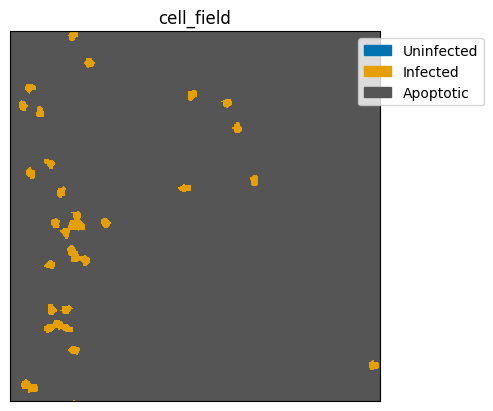

In [21]:
# INSTANTIATE SIMULATION SERVICE (simulation takes a while to start)
VRMPDM = CC3DSimService(output_dir=output_dir)
# Register all the specs defined above in the simulation service
VRMPDM.register_specs(specs)
VRMPDM.register_steppable(steppable=Viral_Replication_ModelSteppable, frequency=1)
# Run the simulation service
VRMPDM.run()
VRMPDM.init()
VRMPDM.start()
#if __name__ == '__main__':

while VRMPDM.current_step < 1000:
    VRMPDM.step()
    #print(VRMPDM.current_step)
clear_output(wait=True)

In [21]:
# SIM VISUALIZATION (does not work in Binder)

#cell_view = VRMPDM.visualize()
#virus_view = VRMPDM.visualize()
#virus_view.field_name = "virus"  # Set the field to visualize

#frame_grid = cc3djgf(cols=2)
#frame_grid.set_frame(cell_view, row=0, col=0)
#frame_grid.set_frame(virus_view, row=0, col=1)
# frame_grid.control_panel()
#display(VRMPDM.jupyter_run_button())
#frame_grid.show()

Index(['time ', ' totIFNc ', ' dead ', ' infected ', ' totVirus ', ' IFNmRNA ',
       ' NS1 '],
      dtype='object')


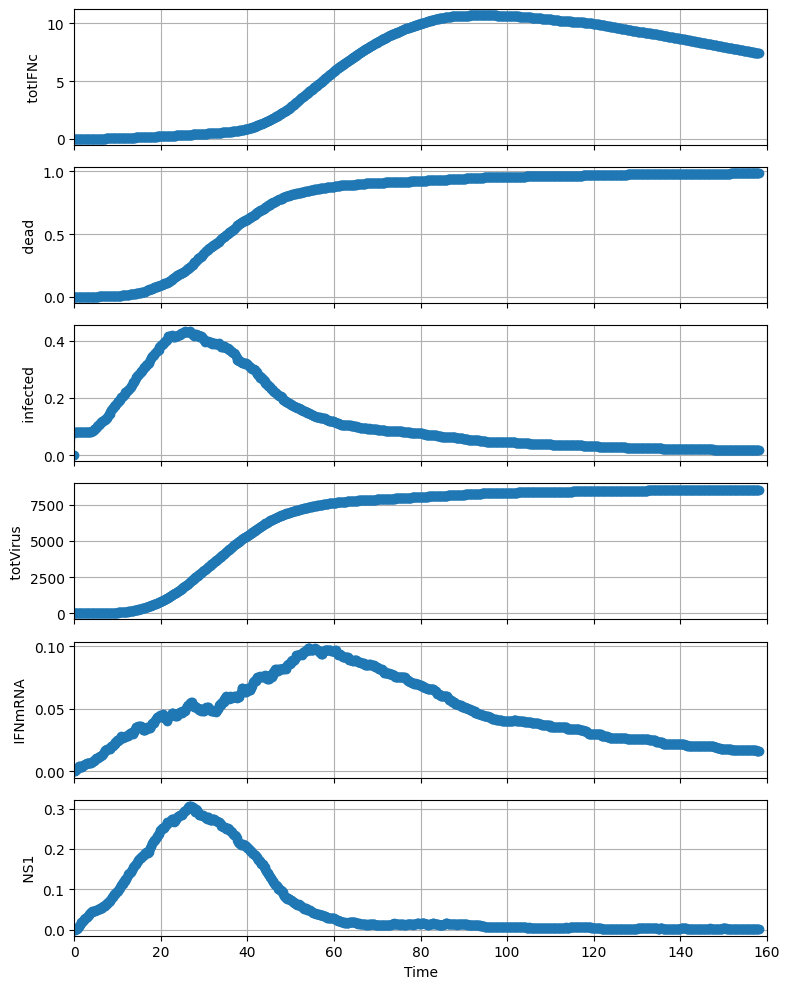

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
working_dir = os.getcwd()
output_folder = os.path.join(working_dir, "output")
file_name = f'output.txt'
output_file = os.path.join(output_folder, file_name)
df = pd.read_csv(output_file, delimiter="\t", header=0)
print(df.columns)
# Ensure the 'time' column is sorted
df = df.sort_values(by=df.columns[0])

# Define variables to plot
variables = [df.columns[i] for i in range(1, len(df.columns))]

# Create subplots
fig, axes = plt.subplots(len(variables), 1, figsize=(8, 10), sharex=True)

for ax, var in zip(axes, variables):
    ax.plot(df[df.columns[0]], df[var], marker="o", linestyle="-")
    plt.xlim(0, 160) 
    #plt.ylim(0, 1) 
    ax.set_ylabel(var)
    ax.grid(True)

# Label the x-axis only on the last subplot
axes[-1].set_xlabel("Time")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
